In [1]:
# install torch again if the session expired
!pip3 install torch torchvision

# Visual understanding of Convnets

Up to now, you have seen how to use neural networks to perform a number of tasks, from discriminative tasks such as classification to generative tasks.

But what have the network done internally remains a mystery to us. Can we understand a bit better what each layer is doing?

Roughly, the first layers of the CNN correspond to low level feature extractors, such as edge and corner detectors.
Intermediate layers takes the detectors from the early layers and are able to extract more complex patterns, such as parts of objects.
Finally, later laters are able to represent more complex combinations of parts of objects and textures.

An example visualization is as follows

![](https://cdn-images-1.medium.com/max/1200/1*Ji5QhY9QXBlpNNLH4qAcNA.png)


## Exploring intermediate activations in a pretrained CNN

We will start with a model pre-trained on ImageNet, and will inspect what each layer is doing.


In [2]:
import torch
from torch import nn
import torchvision

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm

import numpy as np

import requests
from io import BytesIO
if not torch.cuda.is_available():
    print('If you are running this notebook in Colab, go to the Runtime menu and select "Change runtime type" to switch to GPU.')
else:
    print('GPU ready to go!')


GPU ready to go!


#### Helper functions for visualization

Let's now implement a few helper functions that will be useful for downloading images and plotting.

In [0]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

def imshow(img):
    """
    Convenience wrapper around plt.imshow
    """
    if isinstance(img, Image.Image):
        img = np.array(img)
    elif isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    if img.ndim == 2:
        plt.imshow(img, cmap=plt.get_cmap('jet'), interpolation='bicubic')
    else:
        plt.imshow(img, interpolation='bicubic')
    plt.axis('off')

def upsample(image, size):
  """
  Performs a bicubic upsampling of the image
  
  Arguments:
    image: either a np.ndarray, a torch.Tensor
        or a PIL Image
    size: a (width, height) tuple
  """
  if isinstance(image, torch.Tensor):
      image = image.detach().cpu().numpy()
  if isinstance(image, np.ndarray):
      image = (image - image.min()) / (image.max() - image.min())
      image = Image.fromarray(image)
  image = image.resize(size, resample=Image.BICUBIC)
  return np.array(image)

def blend(image, activation, alpha=0.5):
    """
    blend two images together
    
    Arguments:
      image: a PIL Image
      activation: either a np.ndarray, a torch.Tensor
        or a PIL Image
    """
    activation = upsample(activation, image.size)
    activation = cm.jet(activation, bytes=True)
    activation = Image.fromarray(activation).convert('RGB')
    blended = Image.blend(image, activation, alpha)
    return np.array(blended)

### The model

We will be using a ResNet model pre-trained on ImageNet.
Thanks to `torchvision`, it's very easy to obtain pre-trained models.
But `torchvision` only provide models that return a classification score, so we will be
adapting the models from `torchvision` to also return intermediate layers.

Adapting a model requires understanding what are the constituent building blocks from that model.
The implementation of all models available in `torchvision` can be found [here](https://github.com/pytorch/vision/tree/master/torchvision/models).

More particularly, we can see [in those lines](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L103-L111) where a generic ResNet model implements its main building blocks, so we will be using those for our use-case.

In [0]:
from torchvision import models
from torchvision import transforms

import torch.utils.model_zoo as model_zoo

class CustomResNet(models.resnet.ResNet):
    """
    ResNet model that returns all the intermediate
    ResNet blocks
    """
    def forward(self, x):
        """
        Returns a list with the results of each resnet block
        """
        # adds an extra batch dimension for simplicity
        if x.dim() == 3:
          x = x[None]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        layers = [self.layer1, self.layer2, self.layer3, self.layer4]
        result = []
        for layer in layers:
            x = layer(x)
            result.append(x)
        # returns the result, removing the batch dimension
        # for simplicity
        
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x).view(x.size(0), -1, 1, 1)
        result.append(x)
        
        return [r[0] for r in result]

def resnet50(pretrained=False, **kwargs):
    """
    helper function to return a pre-trained model.
    Follows closely the implementation from
    torchvision
    """
    model = CustomResNet(models.resnet.Bottleneck,
                           [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(
            models.resnet.model_urls['resnet50']))
    return model


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # run on GPU if available - recommended!

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).to(device)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).to(device)

normalize = transforms.Normalize(mean.tolist(), std.tolist())
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

# transformation to the input image
# so that it can be fed to the network
img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    normalize
])

Before we load up our altered version of ResNet, let's see what its architecture looks like.

In [5]:
regular_resnet = models.ResNet(models.resnet.Bottleneck, [3, 4, 6, 3])
print(regular_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Let's now create a new model from pre-trained weights and set it to inference mode.

In [0]:
# load a pretrained model and put it in evaluation mode
model = resnet50(pretrained=True)
model.eval()
# as we are not training the model,
# we can set its parameters to not require gradient
for parameter in model.parameters():
  parameter.requires_grad_(False)

model = model.to(device)

### Loading images for inspection

With the help of our utility functions from before, we can load an image from an arbitrary url.

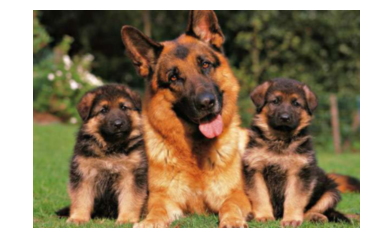

In [7]:
image = load('http://www.zooclub.ru/attach/26000/26132.jpg')
imshow(image)

Let's perform the data pre-processing to convert the images into something that the network can understand.
This is basically performing the same pre-processing as what was done during the training of the network.

In [0]:
processed_image = img_transform(image)

Now let's evaluate the model on our image

In [9]:
with torch.no_grad():
    outputs = model(processed_image.to(device))

print([output.shape for output in outputs])

[torch.Size([256, 64, 96]), torch.Size([512, 32, 48]), torch.Size([1024, 16, 24]), torch.Size([2048, 8, 12]), torch.Size([1000, 1, 1])]


### Defining how to visualize the feature maps

Our model will be returning a set of feature maps that are high-dimensional images (containing possibly thousands of channels, in our example just above up to 2048 channels). How to visualize such high-dimensional images?

One of the simplest things to do is to consider the norm over all the channels, and display it as a heat map. This is what we will be doing next:

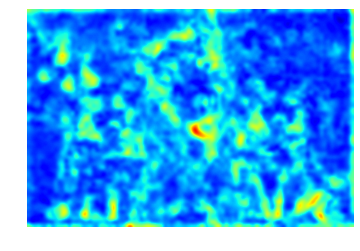

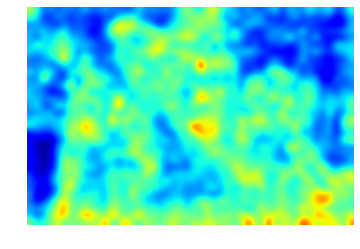

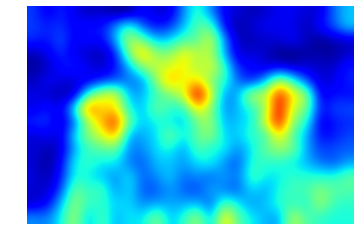

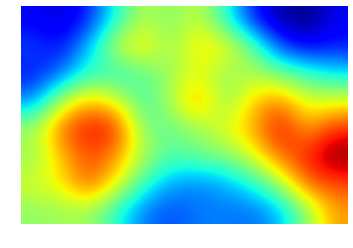

In [10]:
# get the activations of the network for each layer, by just
# computing the norm over the channel dimension
activations = [output.norm(2, dim=0) for output in outputs]

for activation in activations[:-1]:
  imshow(activation)
  plt.show()

Interesting!
By looking at the first activations of the network, we see that it pays attention to small details and contours, while the higher levels contain more semantic information, like the faces of the dogs.

For easier visualization, let's blend the original image with the activation from the third layer of the network

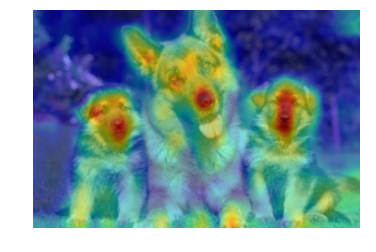

In [11]:
imshow(blend(image, activations[2]))

Nice! It looks like it's really focusing on the dogs faces.

### Exercise
We have tried a very simple transformation on the feature maps (the norm over the channels) to inspect what the network was focusing on.
Try out other possible transformations and see if we can extract more information from the CNN.

**Hint:** Each channel of the feature map alone also contains valuable information. Maybe try visualizing what each channel in the feature map shows?

**Hint:** If you want to visualize a lot of images, it might be useful to have them displayed as a grid of images. For that, you can use [`torchvision.utils.make_grid`](https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid)

In [0]:
# you can experiment here

## Exploring the gradients with respect to each layer

Up to now we have only used the activations of a specific layer.
But another possibility, which is very easy to do with PyTorch, is to leverage the gradients with respect to a specific layer of a network.
By backpropagating until the input image, it is possible to perform gradient descent on the image space.

Let's start with a new image

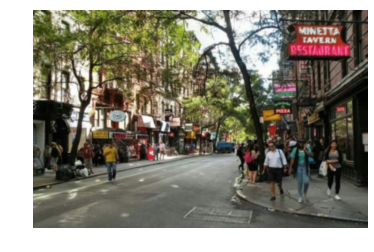

In [13]:
img = load('https://www.magical-planet.com/wp-content/uploads/2018/02/Minetta-Street.jpg')
imshow(img)

What can the network see in this image, if we push it a bit?

Let's take the activations of the network, and modify the original image such that we magnify the original activations of the network.

This will be achieved by using gradient descent

In [0]:
import random
shift = 20
do_random_shifts = True

def random_shift(data):
  return data[:, random.randint(0, shift):-random.randint(1, shift),
             random.randint(0, shift):-random.randint(1, shift)]

# by default, we will be using the 3rd layer to compute the
# gradients
def default_grad_fn(output, layer=2):
    output[layer].backward(output[layer])

def dream(img, n_iter=100,
          grad_fn=default_grad_fn,
          learning_rate=0.02, layer=2):
    """
    This function will take an image img and perform a
    few steps of gradient descent on the image space so
    that we magnify the intermediate activations of the
    image.
    
    Arguments:
      img: a PIL.Image
      n_iter (int): number of iterations of SGD to perform
      grad_fn (function): the function that we will use
        to compute the gradients
      learning_rate (int): the learning rate for the SGD
      
    """
  
    # constants that represent the minimum and maximum
    # value that can be represented in the processed
    # image space
    clamp_min = -mean[:, None, None] / std[:, None, None]
    clamp_max = (1 - mean[:, None, None]) / std[:, None, None]
    clamp_min = clamp_min.to(device)
    clamp_max = clamp_max.to(device)

    # pre-process image
    processed_image = img_transform(img)
    data = processed_image.to(device)
    # perform a few steps of SGD
    for i in range(n_iter):
      # we want to have the gradients wrt the image
      data.requires_grad_()
      x = data
      if do_random_shifts:
        x = random_shift(data)
      output = model(x)
      grad_fn(output, layer=layer)
      # perform the gradient update in the image
      with torch.no_grad():
          # get the mean of the abs of the gradient
          # so that we can have steps which take its
          # magnitude into account
          grad_mean = data.grad.abs().mean()
          # do a simple SGD step
          data += data.grad * learning_rate / grad_mean
          # clip the results so that they are not out of the
          # image range
          data = torch.max(data, clamp_min)
          data = torch.min(data, clamp_max)
    # put image back in the original representation
    # before normalization and also
    # clip image to be between 0 and 1
    result = unnormalize(data.to('cpu')).clamp(0, 1)
    # permute image from CxHxW to HxWxC
    return result.permute(1, 2, 0)

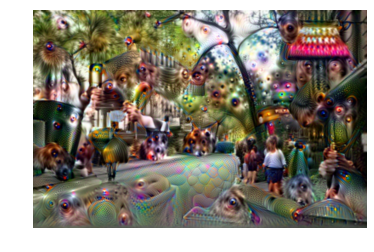

In [15]:
result = dream(img)
imshow(result)

Woah, the cloud got a fish-like skin!

#### Exercise
Try modifying the number of iterations, the learning rate and the layer to see how the results change.

In [0]:
# your modifications here

### Other gradient functions

In the previous exercise, you have tried a few modifications to the gradient function.

But can we control even more what kinds of transformation we want the CNN to apply.

For example. what if we want the network to put more emphasis on the features that are
activated from another image?

Let's recompute the activations from the first image, and use it as a guide for what we would
like the features of the new image to look like

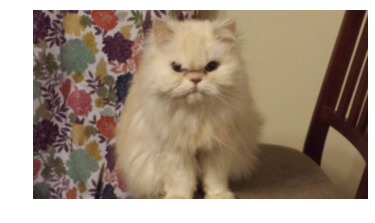

In [20]:
# re-load the image of the dogs and compute the features
image = load('https://scontent.xx.fbcdn.net/v/t1.0-9/1514464_1612894598940963_767128985582791686_n.jpg?_nc_cat=109&_nc_log=1&_nc_oc=AQm4GqZjYJ9y5zFNSc457jOl27WfQI4rhKtwmvhiJ94o02YZJOF2_2X2XmpX-Ab-KXAAM0tQQISk7rI_BGE10XRw&_nc_ht=scontent.xx&oh=1d7cf6b85f65444831c6236f369f66e2&oe=5D2DD72D')
# image = load('https://scontent.xx.fbcdn.net/v/t1.0-9/22279611_2049734068590345_5271692777557742990_n.jpg?_nc_cat=101&_nc_log=1&_nc_oc=AQkBOM6K6d59oV_AAqzt9L3g_RCqxuKH5AJ62pWoMxnSP0oXJrLRE2LG1_IIeVJJ2OCN_4AHKIItgPekkAXE8h8o&_nc_ht=scontent.xx&oh=a2352dbcc2a60b2cc84d247d14acab40&oe=5D3D2CBD')
# image = load('http://www.zooclub.ru/attach/26000/26132.jpg')
imshow(image)
processed_image = img_transform(image)
data = processed_image.to(device)
guide = model(data)

# define a new gradient update function
# that takes the features from another 
# image as a guide
def my_grad_fn(output, layer=2):
  # let's use the result from the 3rd layer
  o = output[layer]
  g = guide[layer]
  shape = o.shape
  o = o.view(o.shape[0], -1)
  g = g.view(g.shape[0], -1)
  # compute the dot product (similarity)
  # of the features for each spacial location
  r = torch.matmul(o.t(), g)
  # and take the max feature activation
  # per spatial location
  r = g[:, r.argmax(1)]
  r = r.view(shape)
  # use it as the gradient for the layer
  output[layer].backward(r)

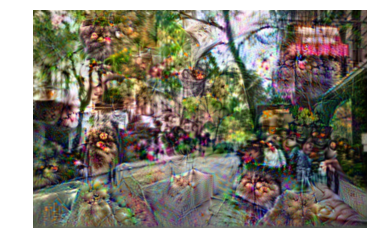

In [26]:
imshow(dream(img, grad_fn=my_grad_fn, layer=3, n_iter=500))

deep-mu-1-layer-1-iter-050.png


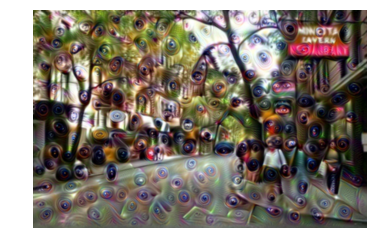

deep-mu-1-layer-1-iter-100.png


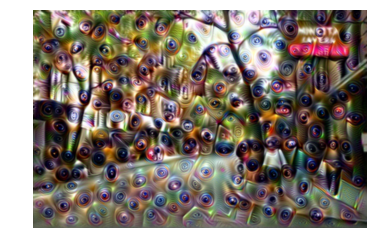

deep-mu-1-layer-1-iter-150.png


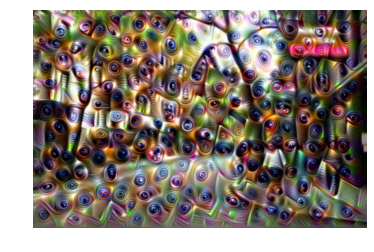

deep-mu-1-layer-1-iter-200.png


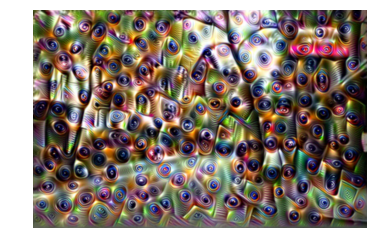

deep-mu-1-layer-2-iter-050.png


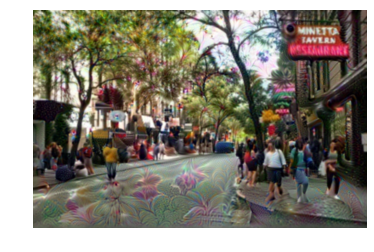

deep-mu-1-layer-2-iter-100.png


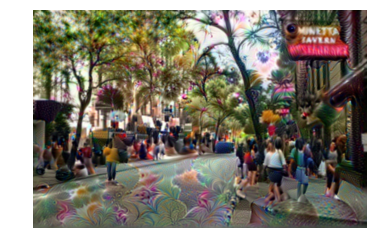

deep-mu-1-layer-2-iter-150.png


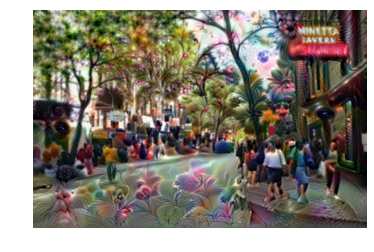

deep-mu-1-layer-2-iter-200.png


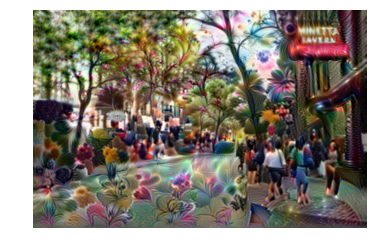

deep-mu-1-layer-3-iter-050.png


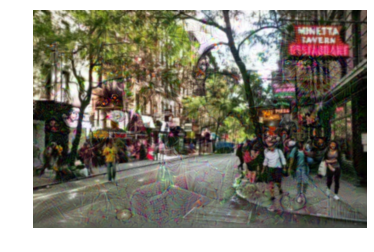

deep-mu-1-layer-3-iter-100.png


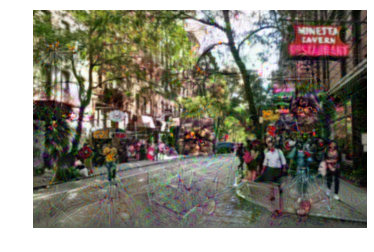

deep-mu-1-layer-3-iter-150.png


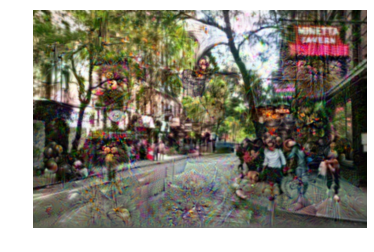

deep-mu-1-layer-3-iter-200.png


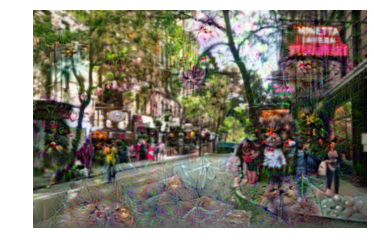

In [21]:
# result = dream(img, grad_fn=my_grad_fn, n_iter=200)
# imshow(result)
for l in [1,2,3]:
  for i in [50, 100, 150, 200, 250]:
    print('deep-mu-1-layer-{}-iter-{:03d}.png'.format(l, i))
    imshow(dream(img, grad_fn=my_grad_fn, layer=l, n_iter=i))
    plt.show()
    

I can see dogs in the clouds!

### Exercise
Try out different layers and images.
Also, maybe try out different gradient functions and see if you can enforce other constraints in to appear in your image.

In [19]:
# you can experiment here.
# this is an example to get you started

def my_grad_fn2(output):
    grad_ = torch.zeros(1000, 1, 1, device=device)
    # use the class correspondences from ImageNet
    # which can be found in https://github.com/torch/tutorials/blob/master/7_imagenet_classification/synset_words.txt
    # to set the focus on dogs and cats
    grad_[153] = 1
    grad_[281] = 1
    output[4].backward(grad_)

    
result = dream(img, grad_fn=my_grad_fn2)
imshow(result)

TypeError: ignored

That's it.

With this notebook, you hopefully got a bit better understanding on how to perform operations with gradients in PyTorch,
and also what the activations of internal layers of CNNs look like.